In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.utils import to_categorical
import keras
import keras_tuner
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input
from keras import backend as K
from keras.callbacks import EarlyStopping



### Initializations

In [3]:
cardboard_files = glob.glob("Cardboard/*.s2p")
metal_files = glob.glob("Metal/*.s2p")
plastic_files = glob.glob("Plastic/*.s2p")
outlier = np.loadtxt("test/Co0s0_outlier.s2p")

In [4]:
def count_scans(filenames, classes):
    counts = []
    for c in classes:
        for i in range(34):
            x = sum(1 for name in filenames if name.__contains__(f'{c}o{i}s'))
            if x != 0:
                counts.append(x)
    return counts

In [5]:
c_scans=count_scans(cardboard_files, ["c"])
print(c_scans)
print(len(c_scans))
print(np.mean(c_scans))
np.median(c_scans)

[9, 17, 13, 22, 15, 10, 9, 14, 11, 16, 5, 12, 11, 11, 15, 20, 13, 12, 11, 10, 9, 10, 8, 9, 15, 15, 10, 14, 12, 6]
30
12.133333333333333


11.5

In [6]:
p_scans=count_scans(plastic_files, ["p"])
print(p_scans)
print(len(p_scans))
print(np.mean(p_scans))
np.median(p_scans)

[10, 7, 11, 17, 14, 10, 10, 11, 10, 8, 15, 11, 11, 15, 11, 11, 11, 8, 10, 13, 10, 13, 16, 15, 7, 10, 12, 14, 11, 11, 16, 9, 7]
33
11.363636363636363


11.0

In [7]:
m_scans=count_scans(metal_files, ["m"])
print(m_scans)
print(len(m_scans))
print(np.mean(m_scans))
np.median(m_scans)

[14, 14, 7, 10, 11, 7, 15, 12, 10, 12, 10, 10, 10, 12, 13, 9, 12, 12, 11, 12, 11, 12, 12, 13, 6, 11, 12, 8, 12, 8, 10, 12, 11, 12]
34
10.970588235294118


11.5

In [8]:
def dataset(filepaths):
    dataset = np.empty((len(filepaths), 101, 5))
    for index, file in enumerate(filepaths):
        data = np.loadtxt(file, skiprows = 1, usecols = (0,1,2,3,4))
        ##dataset = np.concatenate((dataset, data), axis = 0)
        dataset[index] = data
    return dataset

In [9]:
files = cardboard_files + metal_files + plastic_files
print(len(files))
scans = count_scans(files, ["c", "m", "p"])
data = dataset(files)
data = np.delete(data, 0, 2)
data.shape

1112


(1112, 101, 4)

In [10]:
c_obj_classes = np.zeros([len(c_scans), 1])
m_obj_classes = np.ones([len(m_scans), 1])
p_obj_classes = np.ones([len(p_scans), 1])
p_obj_classes[p_obj_classes == 1] = 2
obj_classes = np.concatenate((c_obj_classes, m_obj_classes, p_obj_classes))

## Hyperparameter optimization

In [12]:
def create_Xy(data, index, scans, classes, files):

    X = np.empty((0, 101, 4))
    y = np.empty((1))
    
    #arrange scans into dataset
    for item in index:
        if classes[item] == 0:
            c = "c"
            label = 0
            i = item
        
        elif classes[item] == 1:
            c = "m"
            label = 1
            i = item - 30

        else:
            c = "p"
            label = 0
            i = item - 64
                
        for name, file in zip(files, data):
            if name.__contains__(f'{c}o{i}s'):
                X = np.vstack([X, np.expand_dims(file, axis=0)])
                y = np.vstack([y, label])

    
    y = np.delete(y, (0), axis=0)
    r = np.random.permutation(len(y))
    X, y = X[r], y[r]
    
    return X, y

In [13]:
def item_wise_split(scans, classes, filenames, dataset, seed):

    #split items
    item_idx = list(range(len(scans)))
    train, test = train_test_split(item_idx, test_size = 0.1, random_state = seed, stratify = classes)
    train, val = train_test_split(train, test_size = 0.1, random_state = seed, stratify = classes[train])

    X_train, y_train = create_Xy(dataset, train, scans, classes, filenames)
    
    X_test, y_test = create_Xy(dataset, test, scans, classes, filenames)
    
    X_val, y_val = create_Xy(dataset, val, scans, classes, filenames)
    
    return (X_train, y_train), (X_test, y_test), (X_val, y_val)



In [14]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = item_wise_split(scans, obj_classes, files, data, 2)

In [15]:
unique, counts = np.unique(y_train, return_counts=True)

dict(zip(unique, counts))

{0.0: 595, 1.0: 310}

### Trial 1

In [17]:
def build_model(hp):
    input_shape = (101, 4)
    m_type = hp.Int('type', min_value=1, max_value=4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    if m_type == 1:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 2:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))

    if m_type == 3:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 4:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model,
    objective='val_loss',
    executions_per_trial=1,
    directory = 'bu_trial1',
    project_name = 'bu_trial1'
)

Reloading Tuner from bu_trial1\bu_trial1\tuner0.json


In [19]:
Gtuner.search(X_train, y_train, epochs=400, validation_data=(X_val, y_val), verbose = 2)

In [20]:
Gtuner.results_summary()

Results summary
Results in bu_trial1\bu_trial1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0005 summary
Hyperparameters:
type: 3
optimizer: rmsprop
Score: 5.357227106372875e-09

Trial 0006 summary
Hyperparameters:
type: 4
optimizer: adam
Score: 1.2757262801699198e-08

Trial 0000 summary
Hyperparameters:
type: 1
optimizer: adam
Score: 3.4188599329354474e-07

Trial 0004 summary
Hyperparameters:
type: 3
optimizer: adam
Score: 1.254470930689422e-06

Trial 0001 summary
Hyperparameters:
type: 1
optimizer: rmsprop
Score: 1.2895326335637947e-06

Trial 0007 summary
Hyperparameters:
type: 4
optimizer: rmsprop
Score: 1.797186087060254e-06

Trial 0003 summary
Hyperparameters:
type: 2
optimizer: rmsprop
Score: 5.257019893178949e-06

Trial 0002 summary
Hyperparameters:
type: 2
optimizer: adam
Score: 1.7992515495279804e-05


In [21]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,473 (380.75 KB)

 Trainable params: 97,473 (380.75 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
predictions = best_model.predict(X_test, verbose=0)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])

Test set accuracy: 0.8644067645072937


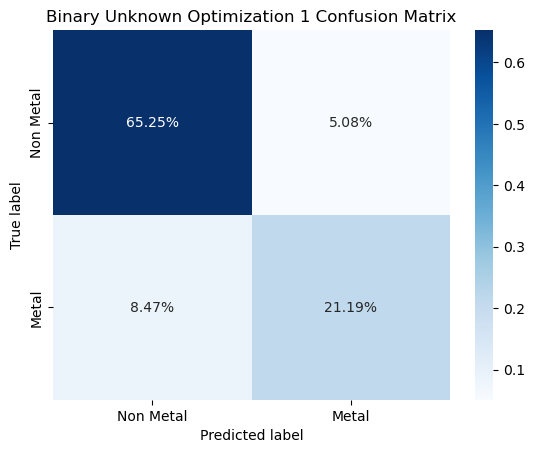

In [23]:
predictions = [round(x[0]) for x in predictions]
categories = ["Non Metal","Metal"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Binary Unknown Optimization 1 Confusion Matrix')
plt.savefig('Graphs/Binary_Unknown_Trial1.png')

### Trial 2

In [25]:
def build_model_2(hp):
    input_shape = (101, 4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    for i in range(hp.Int('num_large_layers', min_value=0, max_value=1)):
        model.add(Dense(256, activation = 'relu'))
    for i in range(hp.Int('num_mid_layers', min_value=1, max_value=3)):
        model.add(Dense(128, activation = 'relu'))
    for i in range(hp.Int('num_small_layers', min_value=3, max_value=6)):
        model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [26]:
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model_2,
    objective='val_loss',
    executions_per_trial=1,
    directory = 'bu_trial2',
    project_name = 'bu_trial2'
)

Reloading Tuner from bu_trial2\bu_trial2\tuner0.json


In [27]:
Gtuner.search(X_train, y_train, epochs=500, validation_data=(X_val, y_val), verbose = 2)

In [28]:
Gtuner.results_summary()

Results summary
Results in bu_trial2\bu_trial2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0009 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 3
num_small_layers: 4
Score: 6.812629571584239e-09

Trial 0020 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 3
num_small_layers: 3
Score: 1.0014688633930291e-08

Trial 0015 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 1
num_small_layers: 6
Score: 1.3529558806624209e-08

Trial 0006 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 2
num_small_layers: 5
Score: 1.4409529569547885e-08

Trial 0003 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 1
num_small_layers: 6
Score: 1.8345394536822823e-08

Trial 0016 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 2
num_small_layers: 3
Score: 2.004673760325204e-08

Trial 0018 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 2
num_small_layers: 5
Score: 2.1176131070888005e-08

Trial 0002 s

In [29]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,665 (412.75 KB)

 Trainable params: 105,665 (412.75 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
predictions = best_model.predict(X_test, verbose=0)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])
#labels = ["True Neg","False Pos","False Neg","True Pos"]


Test set accuracy: 0.8728813529014587


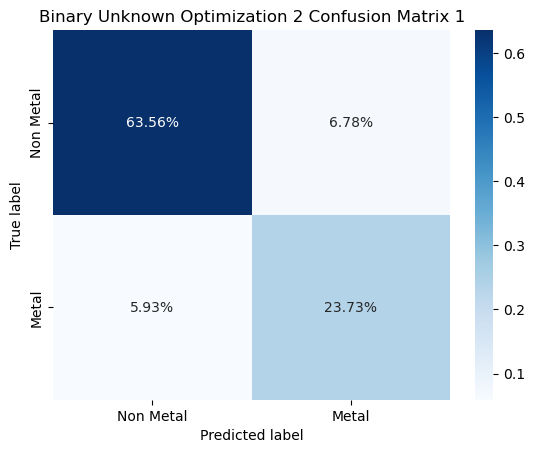

In [31]:
predictions = [round(x[0]) for x in predictions]
categories = ["Non Metal","Metal"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Binary Unknown Optimization 2 Confusion Matrix 1')
plt.savefig('Graphs/Binary_Unknown_Trial2_1.png')

In [32]:
best_model = Gtuner.get_best_models(num_models=2)[1]

predictions = best_model.predict(X_test, verbose=0)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])
#labels = ["True Neg","False Pos","False Neg","True Pos"]
predictions = [round(x[0]) for x in predictions]

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test set accuracy: 0.8559321761131287


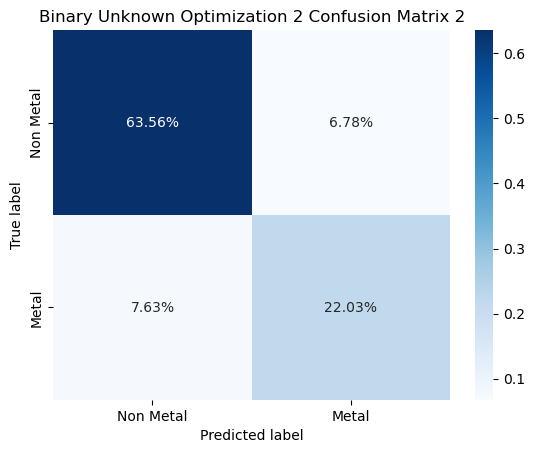

In [33]:
categories = ["Non Metal","Metal"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Binary Unknown Optimization 2 Confusion Matrix 2')
plt.savefig('Graphs/Binary_Unknown_Trial2_2.png')

## K-fold validation of previous models

In [35]:
initializer = keras.initializers.GlorotUniform(seed=42)

In [36]:
def build_k_fold_model():
    input_shape = (101, 4)

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(units=128, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(units=128, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(units=128 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(units=64 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(units=64 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(units=64 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(units=64 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [37]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="binary_model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [38]:
from sklearn.model_selection import StratifiedKFold

accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
cf_matrices = []
objects = list(range(len(scans)))
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for fold, (train, test) in enumerate(skf.split(objects, obj_classes)):
    print(f'Fold {fold + 1}')

    train, val = train_test_split(train, test_size = 0.1, random_state = 2, stratify=obj_classes[train])
    
    X_train, y_train = create_Xy(data, train, scans, obj_classes, files)
    
    X_val, y_val = create_Xy(data, val, scans, obj_classes, files)
    
    X_test, y_test = create_Xy(data, test, scans, obj_classes, files)

    model = build_k_fold_model()
    
    model.fit(X_train, y_train,
              epochs=500,
              batch_size=128,
              validation_data=(X_val, y_val),
              callbacks = [model_checkpoint_callback],
              verbose=0)

    
    model = keras.models.load_model("binary_model.keras")
    
    predictions = model.predict(X_test)
    predictions = [round(x[0]) for x in predictions] 
    accuracy = accuracy_score(y_test, predictions)

    values = precision_recall_fscore_support(y_test, predictions, average='macro')
    cf_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)


    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(values[0])
    recall_per_fold.append(values[1])
    f1_per_fold.append(values[2])
    cf_matrices.append(cf_matrix)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {values[0] * 100:.2f}%')
    print(f'Recall: {values[1] * 100:.2f}%')
    print(f'F1-score: {values[2]:.4f}')

average_accuracy = np.mean(accuracy_per_fold)
average_precision = np.mean(precision_per_fold)
average_recall = np.mean(recall_per_fold)
average_f1 = np.mean(f1_per_fold)
print(f'\nAverage Accuracy Across {10} Folds: {average_accuracy * 100:.2f}%')
print(f'\nAverage Precision Across {10} Folds: {average_precision * 100:.2f}%')
print(f'\nAverage Recall Across {10} Folds: {average_recall * 100:.2f}%')
print(f'\nAverage F1-score Across {10} Folds: {average_f1:.4f}')

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Accuracy: 96.46%
Precision: 97.26%
Recall: 95.45%
F1-score: 0.9621
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-score: 1.0000
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Accuracy: 99.21%
Precision: 99.39%
Recall: 98.89%
F1-score: 0.9913
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Accuracy: 90.18%
Precision: 93.37%
Recall: 86.25%
F1-score: 0.8848
Fold 5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Accuracy: 93.28%
Precision: 95.70%
Recall: 88.24%
F1-score: 0.9109
Fold 6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Accuracy: 99.03%
Precision: 99.30%
Recall: 98.48%
F1-score: 0.9888
Fold 7
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy: 99.26%
Precision: 98.65%
Recall: 99.49%
F1-score: 0.9906
Fold 8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Accuracy: 99.00%
Precision: 98.53%
Recall: 99.25%
F1-score: 0.9888
Fold 9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Accuracy: 97.70%
Precision: 98.28%
Recall: 96.77%
F1-sco

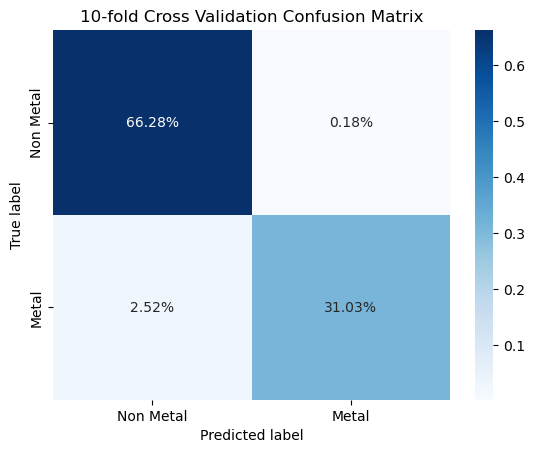

In [39]:
av_cf = sum(cf_matrices)
sns.heatmap(av_cf/np.sum(av_cf), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('10-fold Cross Validation Confusion Matrix')
plt.savefig('Graphs/Binary_Unknown_k-fold.png')